In [1]:
import pyro
import torch
import pyro.distributions as dist
from collections import OrderedDict
from typing import (
    Union,
)
import matplotlib.pyplot as plt

import chirho.contrib.compexp as ep  # TODO rename to expectation_programming (?)

pyro.settings.set(module_local_params=True)

PT = torch.nn.Parameter
TT = torch.Tensor
tt = torch.tensor
UPTT = Union[PT, TT]

## Minimizing Costs of Clean Energy Switch While Meeting Peak Load of Power Grid

A small country is planning to switch its power grid to clean energy. The grid will need to meet annual peak load, but the country would also like to minimize costs. Planners must contend with unknown polynomial scaling of cost, as the country's small size will require non-linear investments to squeeze more capacity out of limited power options.

These factors, however, are correlated — a strong economy will induce higher peak loads, but will also increase technological options to increase capacity.

Policy makers have two knobs to turn. The first is the capacity of the new power grid. The second is a direct investment in energy research and subsidies. This has the effect of reducing the effects of poor cost scaling and decreasing peak load needs due to efficiency.

In [2]:
def unmarginalized_model():

    # Latent economic factor in annual billions in GDP.
    # economic_strength = es = pyro.sample(
    #     "es",
    #     # dist.Normal(loc=100., scale=10.)
    #     dist.Delta(tt(100.))
    # )
    es = tt(100.)

    # Annual peak load in gigawatts.
    raw_peak_load = pyro.sample(
        "rpl", dist.Normal(loc=es / 10., scale=0.5))

    # Exponent of cost scaling per capacity.
    raw_cost_scaling = pyro.sample(
        "rcs", dist.Normal(loc=1. + 0.5 * (1. + ((100. - es) / 100.)), scale=0.1))

    return OrderedDict(
        rpl=raw_peak_load,
        rcs=raw_cost_scaling
    )

# marginal_rpl_rcs_samples = tt([list(unmarginalized_model().values()) for _ in range(20000)])
# marginal_rpl_rcs_mean = torch.mean(marginal_rpl_rcs_samples, dim=0)
# marginal_rpl_rcs_cov = torch.cov(marginal_rpl_rcs_samples.T)

In [3]:
# TODO this needs to trace out rpl and rcs.
# def model():
#     rplrcs = pyro.sample("rplrcs", dist.MultivariateNormal(
#         loc=marginal_rpl_rcs_mean, covariance_matrix=marginal_rpl_rcs_cov))
#
#     return OrderedDict(
#         rpl=rplrcs[0],
#         rcs=rplrcs[1]
#     )
model = unmarginalized_model

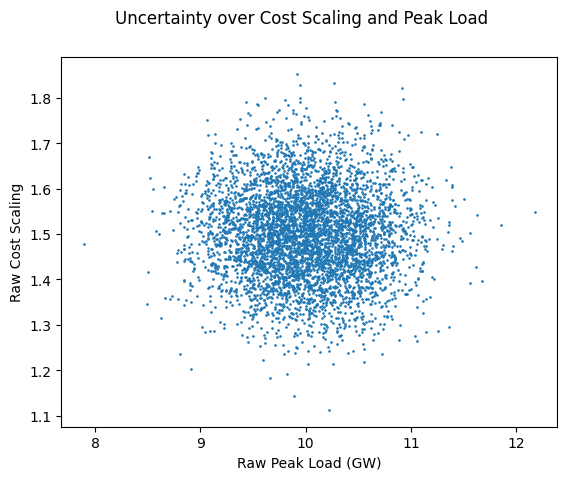

In [4]:
plt.figure()
plt.ylabel("Raw Cost Scaling")
plt.xlabel("Raw Peak Load (GW)")
plt.suptitle("Uncertainty over Cost Scaling and Peak Load")
plt.scatter(*tt([list(model().values()) for _ in range(5000)]).T, s=0.8)
plt.show()

In [5]:
def research_subsidy_outcome(subsidy_opportunity_cost):
    return 1. + torch.log(1. + torch.abs(subsidy_opportunity_cost))/30.

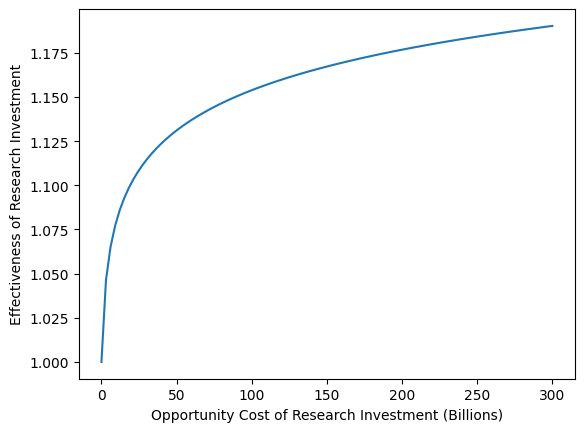

In [6]:
subsidy_val_xx = torch.linspace(0., 300., 100)
plt.ylabel("Effectiveness of Research Investment")
plt.xlabel("Opportunity Cost of Research Investment (Billions)")
plt.plot(subsidy_val_xx, research_subsidy_outcome(subsidy_val_xx))

In [7]:
# Cost in billions to build capacity for a scaled gigawatt.
COST_PER_SCALED_GW = tt(20.)

# Policy parameters: [
#   grid capacity (GW),
#   the opportunity cost (billions) arising from energy research subsidies
# ]
PP_OG = tt([7., 500.])
pp = PT(tt(PP_OG.detach().clone().numpy()))

def build_cost(policy_params):
    def cost_(plcs):
        adjusted_scaling = plcs["rcs"] / research_subsidy_outcome(policy_params[1])
        return policy_params[0] ** adjusted_scaling * COST_PER_SCALED_GW + policy_params[1]
    return cost_

cost = build_cost(pp)

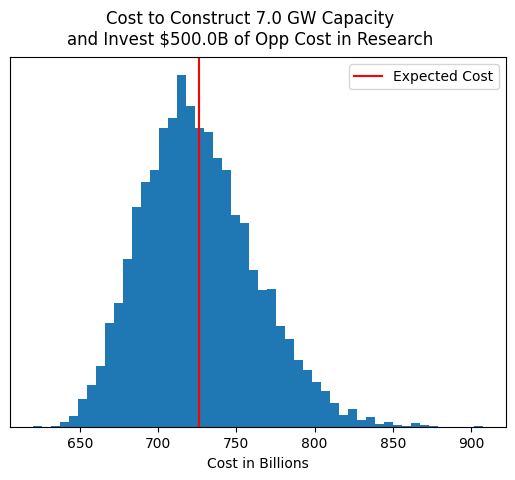

In [8]:
def plot_cost(policy_params):
    plt.figure()
    plt.suptitle(f"Cost to Construct {policy_params[0]} GW Capacity\n"
                 f"and Invest ${policy_params[1]}B of Opp Cost in Research")
    cost_samples = tt([cost(model()).detach() for _ in range(5000)])
    plt.hist(cost_samples, bins=50)
    plt.axvline(x=torch.mean(cost_samples), color='red', label=f"Expected Cost")
    plt.xlabel("Cost in Billions")
    plt.yticks([])
    plt.legend()
    plt.show()
plot_cost(pp)

#### Threshold on Penalized Expected Margin
As a first pass, the country will attempt to minimize costs while keeping the penalized, expected margin over peak load above some threshold.

In [9]:
def penalty(margin_val):
    return 1. - torch.exp(-margin_val)

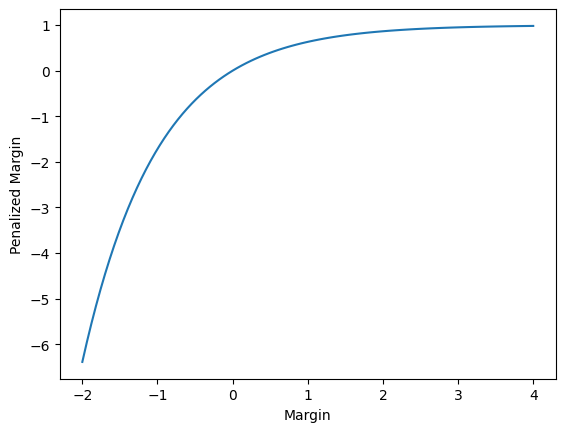

In [10]:
margin_val_xx = torch.linspace(-2., 4., 100)
plt.ylabel("Penalized Margin")
plt.xlabel("Margin")
plt.plot(margin_val_xx, penalty(margin_val_xx))

In [11]:
def build_margin(policy_params):
    def margin_(dadb):
        return policy_params[0] - dadb["rpl"] / research_subsidy_outcome(policy_params[1])
    return margin_
margin = build_margin(pp)

def penalized_margin(dadb):
    # Expected margin of capacity over annual peak load. Energy research also
    #  reduces peak load needs.

    return penalty(margin(dadb))

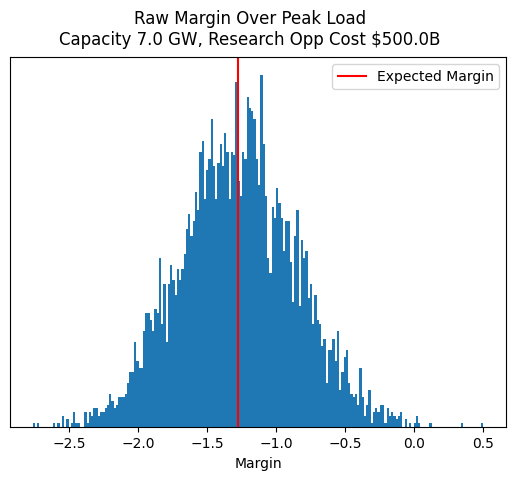

In [12]:
def plot_raw_margin(policy_params, n=5000):
    plt.figure()
    plt.suptitle(f"Raw Margin Over Peak Load\n"
                 f"Capacity {policy_params[0]} GW, "
                 f"Research Opp Cost ${policy_params[1]}B")
    margin_samples = tt([margin(model()).detach() for _ in range(n)])
    plt.hist(margin_samples, bins=200)
    plt.axvline(x=torch.mean(margin_samples), color='red', label=f"Expected Margin")
    plt.xlabel("Margin")
    plt.yticks([])
    plt.legend()
    # plt.show()
plot_raw_margin(pp)

In [13]:
PENALIZED_MARGIN_THRESH_GW = PMT = tt(0.85)

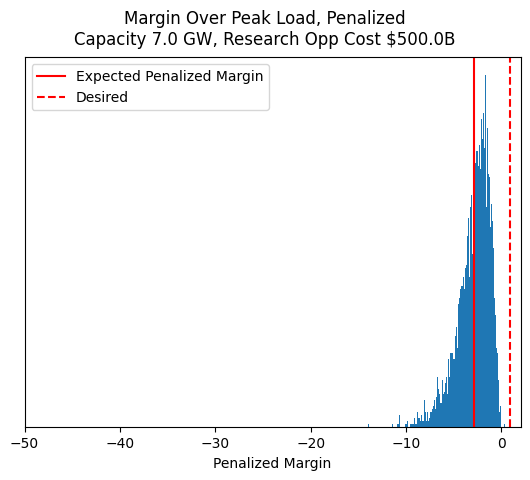

In [14]:
def plot_margin(xlim, policy_params, n=5000):
    plt.figure()
    plt.suptitle(f"Margin Over Peak Load, Penalized\n"
                 f"Capacity {policy_params[0]} GW, "
                 f"Research Opp Cost ${policy_params[1]}B")
    margin_samples = tt([penalized_margin(model()).detach() for _ in range(n)])
    plt.hist(margin_samples, bins=200)
    plt.axvline(x=torch.mean(margin_samples), color='red', label=f"Expected Penalized Margin")
    plt.xlabel("Penalized Margin")
    plt.yticks([])
    plt.axvline(x=PENALIZED_MARGIN_THRESH_GW, color='red', linestyle='dashed', label="Desired")
    plt.legend()
    plt.xlim((xlim, 2.))
    plt.show()
plot_margin(-50., pp)

In [15]:
# The policy objective is to minimize cost while keeping the expected penalized
#  margin below specified threshold.

tau_pmmdo = ep.C(tt(6e2))

# The deconstrained objective minimizes the cost and the degree
#  to which the expected penalized capacity sits below the
#  desired threshold.
# pmmdo_constraint = tau_pmmdo * (ep.E(lambda s: -penalized_margin(s), "pmarg") + ep.C(PMT)).relu()
pmmdo_constraint = - tau_pmmdo * ep.E(penalized_margin, "pmarg")
pmmdo_cost = ep.E(cost, "cost")
penalized_margin_mean_deconstrained_objective = pmmdo = pmmdo_cost + pmmdo_constraint

##### Optimization


In [16]:
N_SAMPLES = 4

In [17]:
class DecisionOptimizer:
    def __init__(
            self,
            flat_dparams: PT,
            model: ep.typedecs.ModelType,
            cost: ep.ComposedExpectation,
            expectation_handler: ep.ExpectationHandler,
            lr: float
    ):
        self.flat_dparams = flat_dparams
        self.model = model
        # ep.ComposedExpectation objects can be auto-differentiated.
        self.cost_grad: ep.ComposedExpectation = cost.grad(self.flat_dparams) if cost is not None else None
        self.expectation_handler = expectation_handler
        self._lr = lr

        self.optim = torch.optim.SGD((self.flat_dparams,), lr=self._lr)

    @property
    def lr(self):
        return self._lr

    @lr.setter
    def lr(self, lr):
        self._lr = lr
        for g in self.optim.param_groups:
            g['lr'] = lr

    def estimate_grad(self):
        self.optim.zero_grad()
        self.flat_dparams.grad = None

        with self.expectation_handler:
            grad_estimate_: TT = self.cost_grad(self.model)

        return grad_estimate_

    def step_grad(self, grad_estimate_):
        self.flat_dparams.grad = grad_estimate_
        self.optim.step()

    def step(self):
        grad_estimate = self.estimate_grad()
        self.step_grad(grad_estimate)

##### Monte Carlo

In [18]:
pmmdo_opt = DecisionOptimizer(
    flat_dparams=pp,
    model=model,
    cost=penalized_margin_mean_deconstrained_objective,
    expectation_handler=ep.MonteCarloExpectationHandler(num_samples=N_SAMPLES),
    lr=1.
)

capacity_param_pmmdo = []
research_param_pmmdo = []

In [19]:
mc_grad_estimates = []

In [20]:
def adjust_grads_(grad):
    # Clip to just a unit vector if exceeding the magnitude of 1.
    grad_mag = torch.norm(grad)
    grad /= torch.max(tt(1.), grad_mag)

    # Rescale the gradient so that the research opportunity cost updates faster than it would otherwise.
    # Also set learning rate.
    grad[1] *= 6e2
    grad *= 2e-2 * 5

In [21]:
MC_N = 1500
for i in range(MC_N):
    grad_estimate = pmmdo_opt.estimate_grad()
    mc_grad_estimates.append(grad_estimate.detach().clone())
    adjust_grads_(grad_estimate)
    pmmdo_opt.step_grad(grad_estimate)

    capacity_param_pmmdo.append(pp[0].item())
    research_param_pmmdo.append(pp[1].item())

In [22]:
mc_pp = pp.detach().clone()  # Store for later plotting.

##### Single Stage SVI TABI

In [23]:
# Reset parameters that were used to build the graphs.
with torch.no_grad():
    pp[:] = PT(tt(PP_OG.detach().clone().numpy()))

In [24]:
ss_tabi_handler = ep.ProposalTrainingLossHandler(
    lr=1e-2 / N_SAMPLES,
    num_samples=N_SAMPLES
)

pmmdo_tabi_grad = pmmdo.grad(params=pp, split_atoms=True)

ss_tabi_handler.register_guides(
    ce=pmmdo_tabi_grad,
    model=model,
    auto_guide=pyro.infer.autoguide.AutoMultivariateNormal,
    auto_guide_kwargs=dict(init_scale=1.0)
    # auto_guide=pyro.infer.autoguide.AutoIAFNormal,
    # auto_guide_kwargs=dict(num_transforms=2)
)

In [25]:
pmmdo_tabi_opt = DecisionOptimizer(
    flat_dparams=pp,
    model=model,
    cost=None,
    expectation_handler=ss_tabi_handler,
    lr=1.
)
pmmdo_tabi_opt.cost_grad = pmmdo_tabi_grad

capacity_param_pmmdo_tabi = []
research_param_pmmdo_tabi = []

# DEBUG
estimates = dict()

# DEBUG
with ss_tabi_handler:
# with ep.MonteCarloExpectationHandler(num_samples=N_SAMPLES):
    for p in pmmdo_tabi_grad.parts:
        pestimates = [] if p.name not in estimates else estimates[p.name]
        print(p.name)
        for i in range(3000):
            print(f"{i:04d}", end='\r')
            pestimates.append(p(model))
        estimates[p.name] = pestimates

# DEBUG
for pname, ests in estimates.items():
    plt.figure(figsize=(5, 1))
    plt.suptitle(pname)
    ests = torch.stack(ests)
    print(f"{pname} isfinite", (~torch.isfinite(ests)).sum().detach())
    plt.plot(-ests.detach().log().numpy(), label=pname, linewidth=0.1)

# DEBUG
mc_estimates = dict()

# DEBUG
with ep.MonteCarloExpectationHandler(1):
# with ep.MonteCarloExpectationHandler(num_samples=N_SAMPLES):
    for p in pmmdo_tabi_grad.parts:
        pestimates = [] if p.name not in mc_estimates else mc_estimates[p.name]
        print(p.name)
        for i in range(3000):
            print(f"{i:04d}", end='\r')
            pestimates.append(p(model))
        mc_estimates[p.name] = pestimates

# DEBIG
# Compare estimates and mc_estimates in histograms.
for pname in estimates.keys():

    # # Count the number of non finite values in each.
    # print(f"{pname} isfinite", (~torch.isfinite(torch.stack(estimates[pname]))).sum().detach())
    # print(f"{pname} isfinite", (~torch.isfinite(torch.stack(mc_estimates[pname]))).sum().detach())

    plt.figure(figsize=(5, 2))
    plt.suptitle(pname)
    plt.hist(torch.stack(mc_estimates[pname]).detach(), label=pname, linewidth=1., bins=30, fill=False, histtype='step')
    plt.hist(torch.stack(estimates[pname]).detach(), label=pname, linewidth=1., bins=30, fill=False, histtype='step')

In [26]:
tabi_grad_estimates = []

In [27]:
TABI_N = MC_N
BURNIN = 1000
for i in range(TABI_N + BURNIN):
    grad_estimate = pmmdo_tabi_opt.estimate_grad()

    print(f"{i:04d}", end='\r')

    if i < BURNIN:
        continue

    tabi_grad_estimates.append(grad_estimate.detach().clone())

    if not torch.isfinite(grad_estimate).all():
        continue

    adjust_grads_(grad_estimate)

    pmmdo_tabi_opt.step_grad(grad_estimate)

    capacity_param_pmmdo_tabi.append(pp[0].item())
    research_param_pmmdo_tabi.append(pp[1].item())

In [28]:
pp

Parameter containing:
tensor([11.2090, 64.4622], requires_grad=True)

In [29]:
tt_grad_estimates = torch.stack(tabi_grad_estimates).detach()
tt_mc_grad_estimates = torch.stack(mc_grad_estimates).detach()

In [30]:
# Remove non-finite values from each.
tt_grad_estimates_no_nan = tt_grad_estimates[torch.isfinite(tt_grad_estimates).all(dim=1)]
assert torch.isfinite(tt_grad_estimates_no_nan).all()
tt_mc_grad_estimates_no_nan = tt_mc_grad_estimates[torch.isfinite(tt_mc_grad_estimates).all(dim=1)]
assert torch.isfinite(tt_mc_grad_estimates_no_nan).all()

In [31]:
tt_grad_estimates_no_nan.abs().quantile(.99), tt_mc_grad_estimates_no_nan.abs().quantile(.99)

(tensor(107.6025), tensor(83.0665))

In [32]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Courtesy of chatgpt
def sliding_window_std_linear_fit(arr, window_size):
    """
    Calculate the standard deviation of the residuals around a linear regression fit
    to a 1D numpy array `arr` over a symmetric sliding window of size `window_size`.

    Parameters:
    - arr: 1D numpy array
    - window_size: the size of the window (should be an odd integer)

    Returns:
    - std_devs: 1D numpy array containing the standard deviation of the residuals within each window
    """
    half_window = window_size // 2
    std_devs = np.zeros_like(arr)

    # Iterate over the array
    for i in range(len(arr)):
        # Determine the start and end of the window
        start = max(0, i - half_window)
        end = min(len(arr), i + half_window + 1)

        # Fit linear regression to the window
        if end - start > 1:  # Need at least two points to fit
            x_window = np.arange(start, end).reshape(-1, 1)
            y_window = arr[start:end]
            model = LinearRegression().fit(x_window, y_window)

            # Calculate the residuals
            y_pred = model.predict(x_window)
            residuals = y_window - y_pred

            # Calculate the standard deviation of the residuals
            std_devs[i] = np.std(residuals)
        else:
            std_devs[i] = 0  # Not enough points to fit a line

    return std_devs

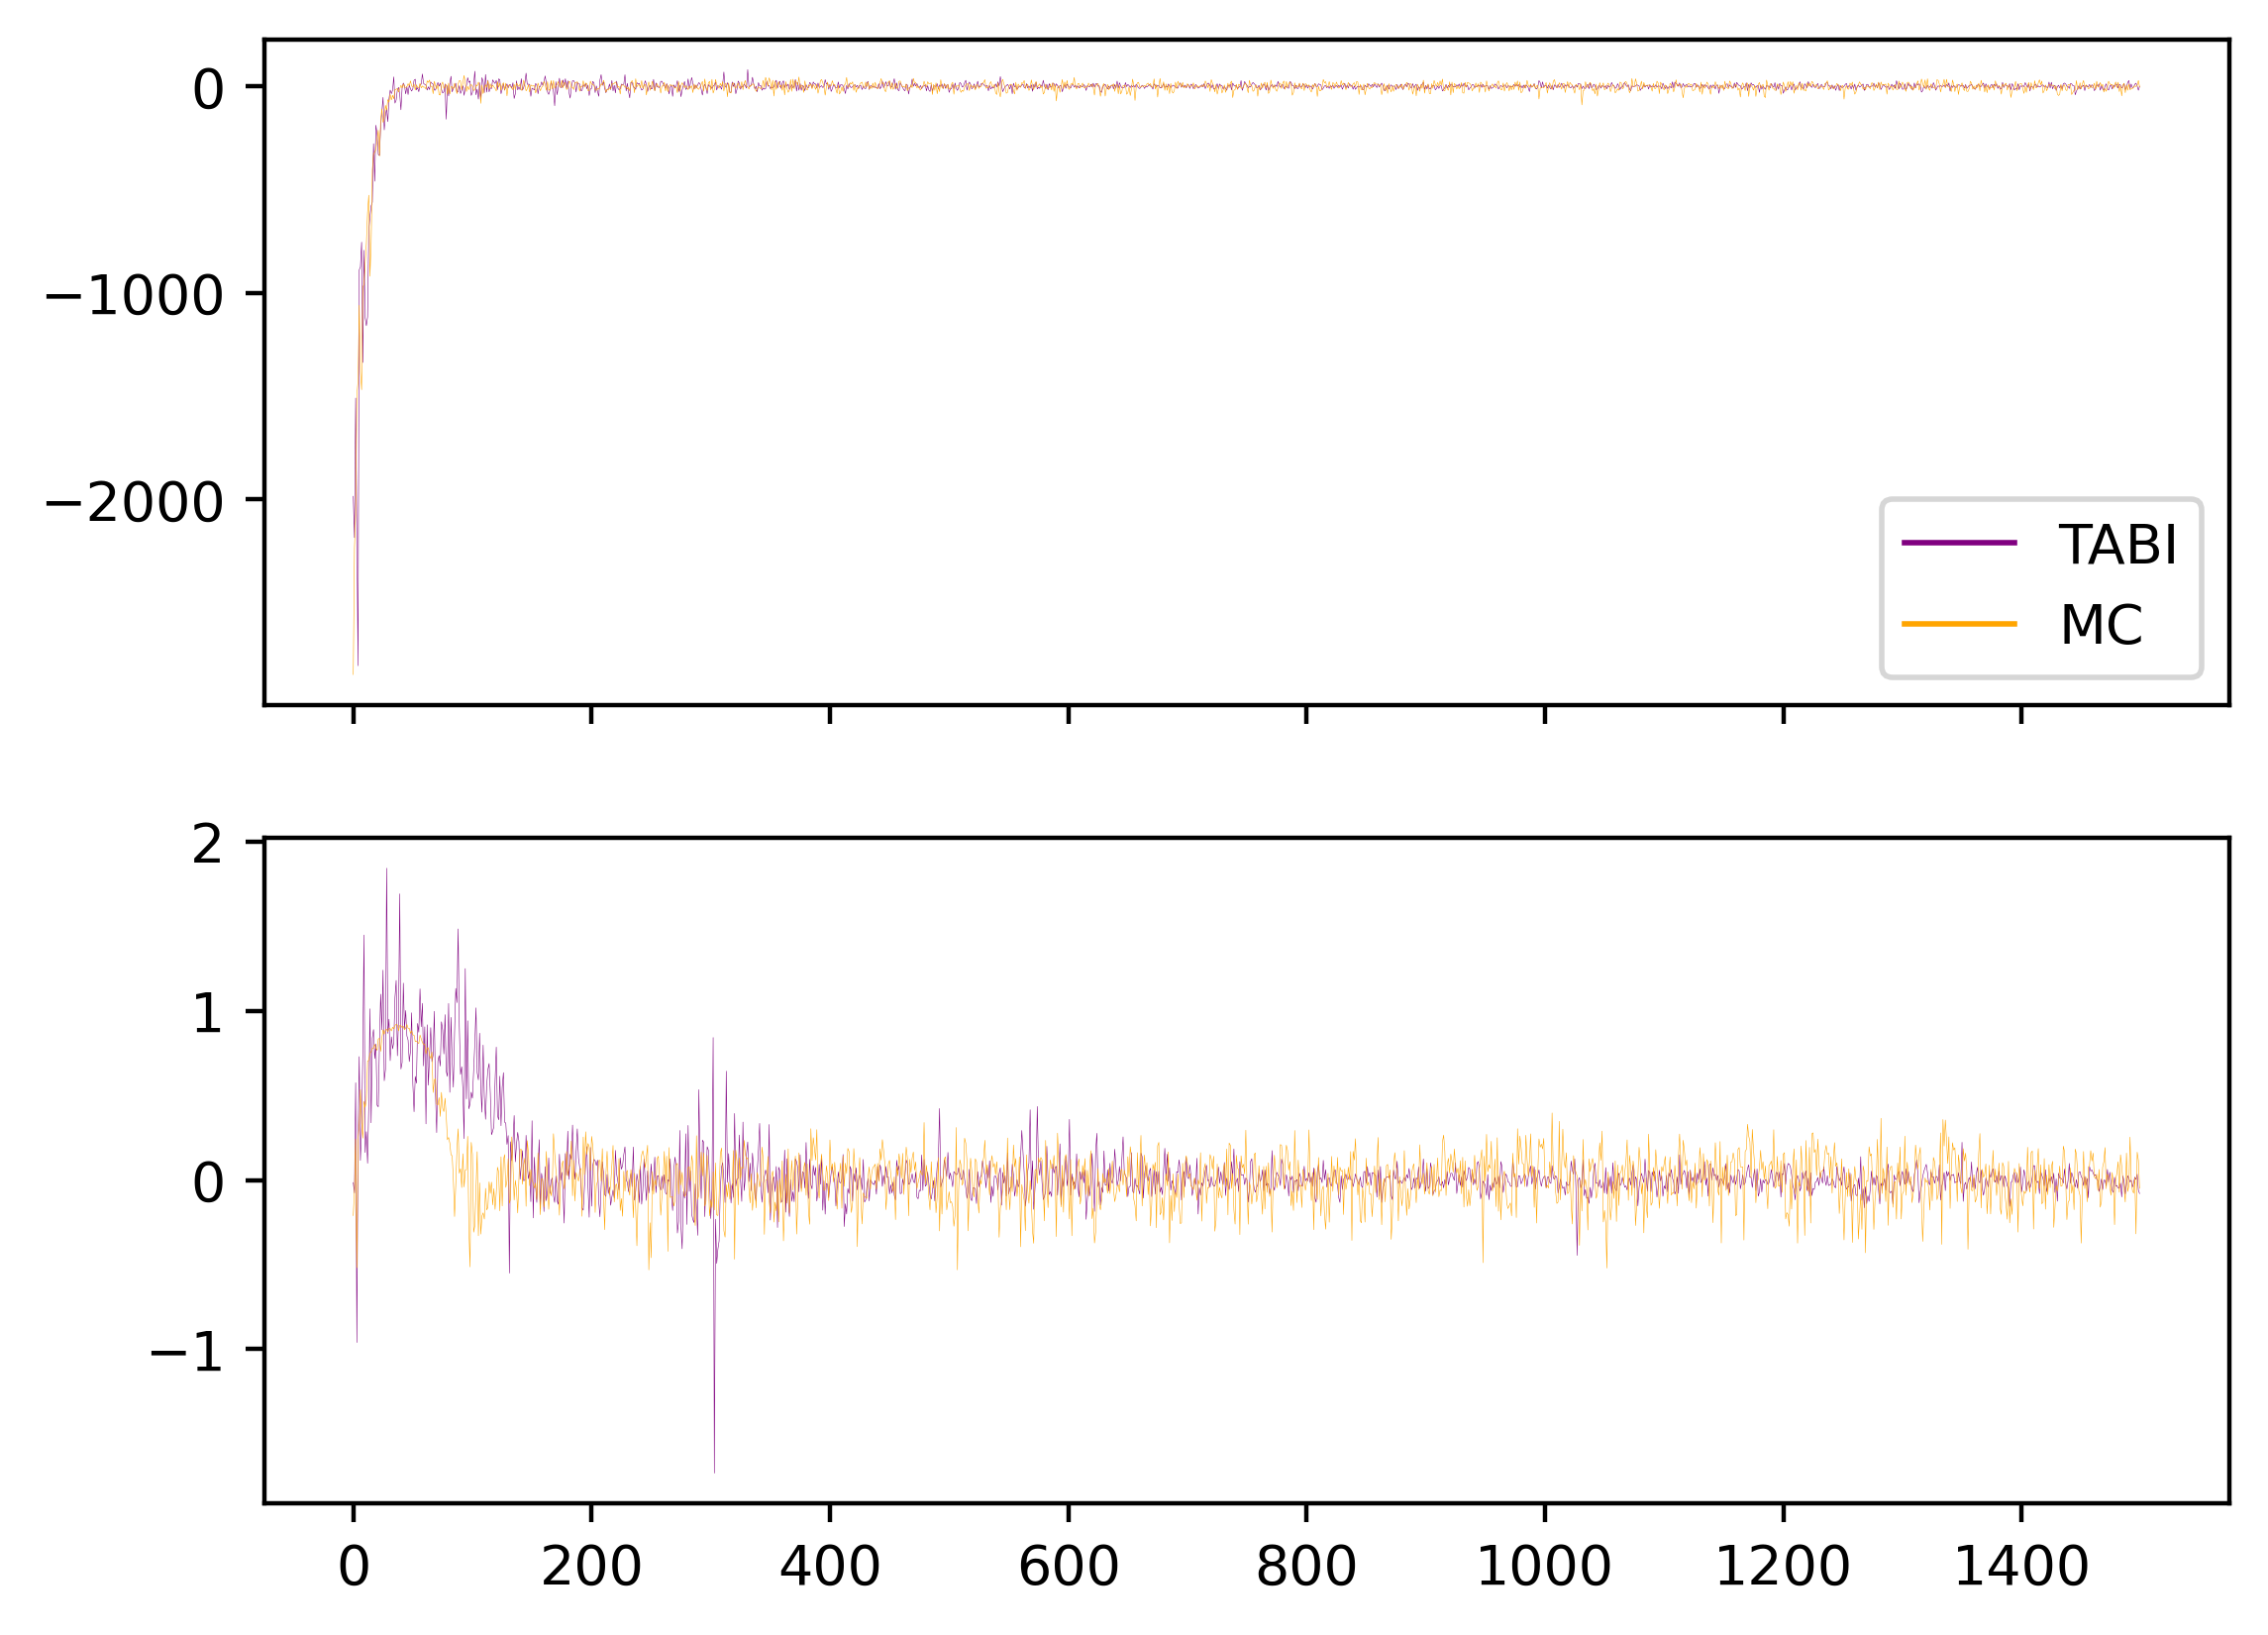

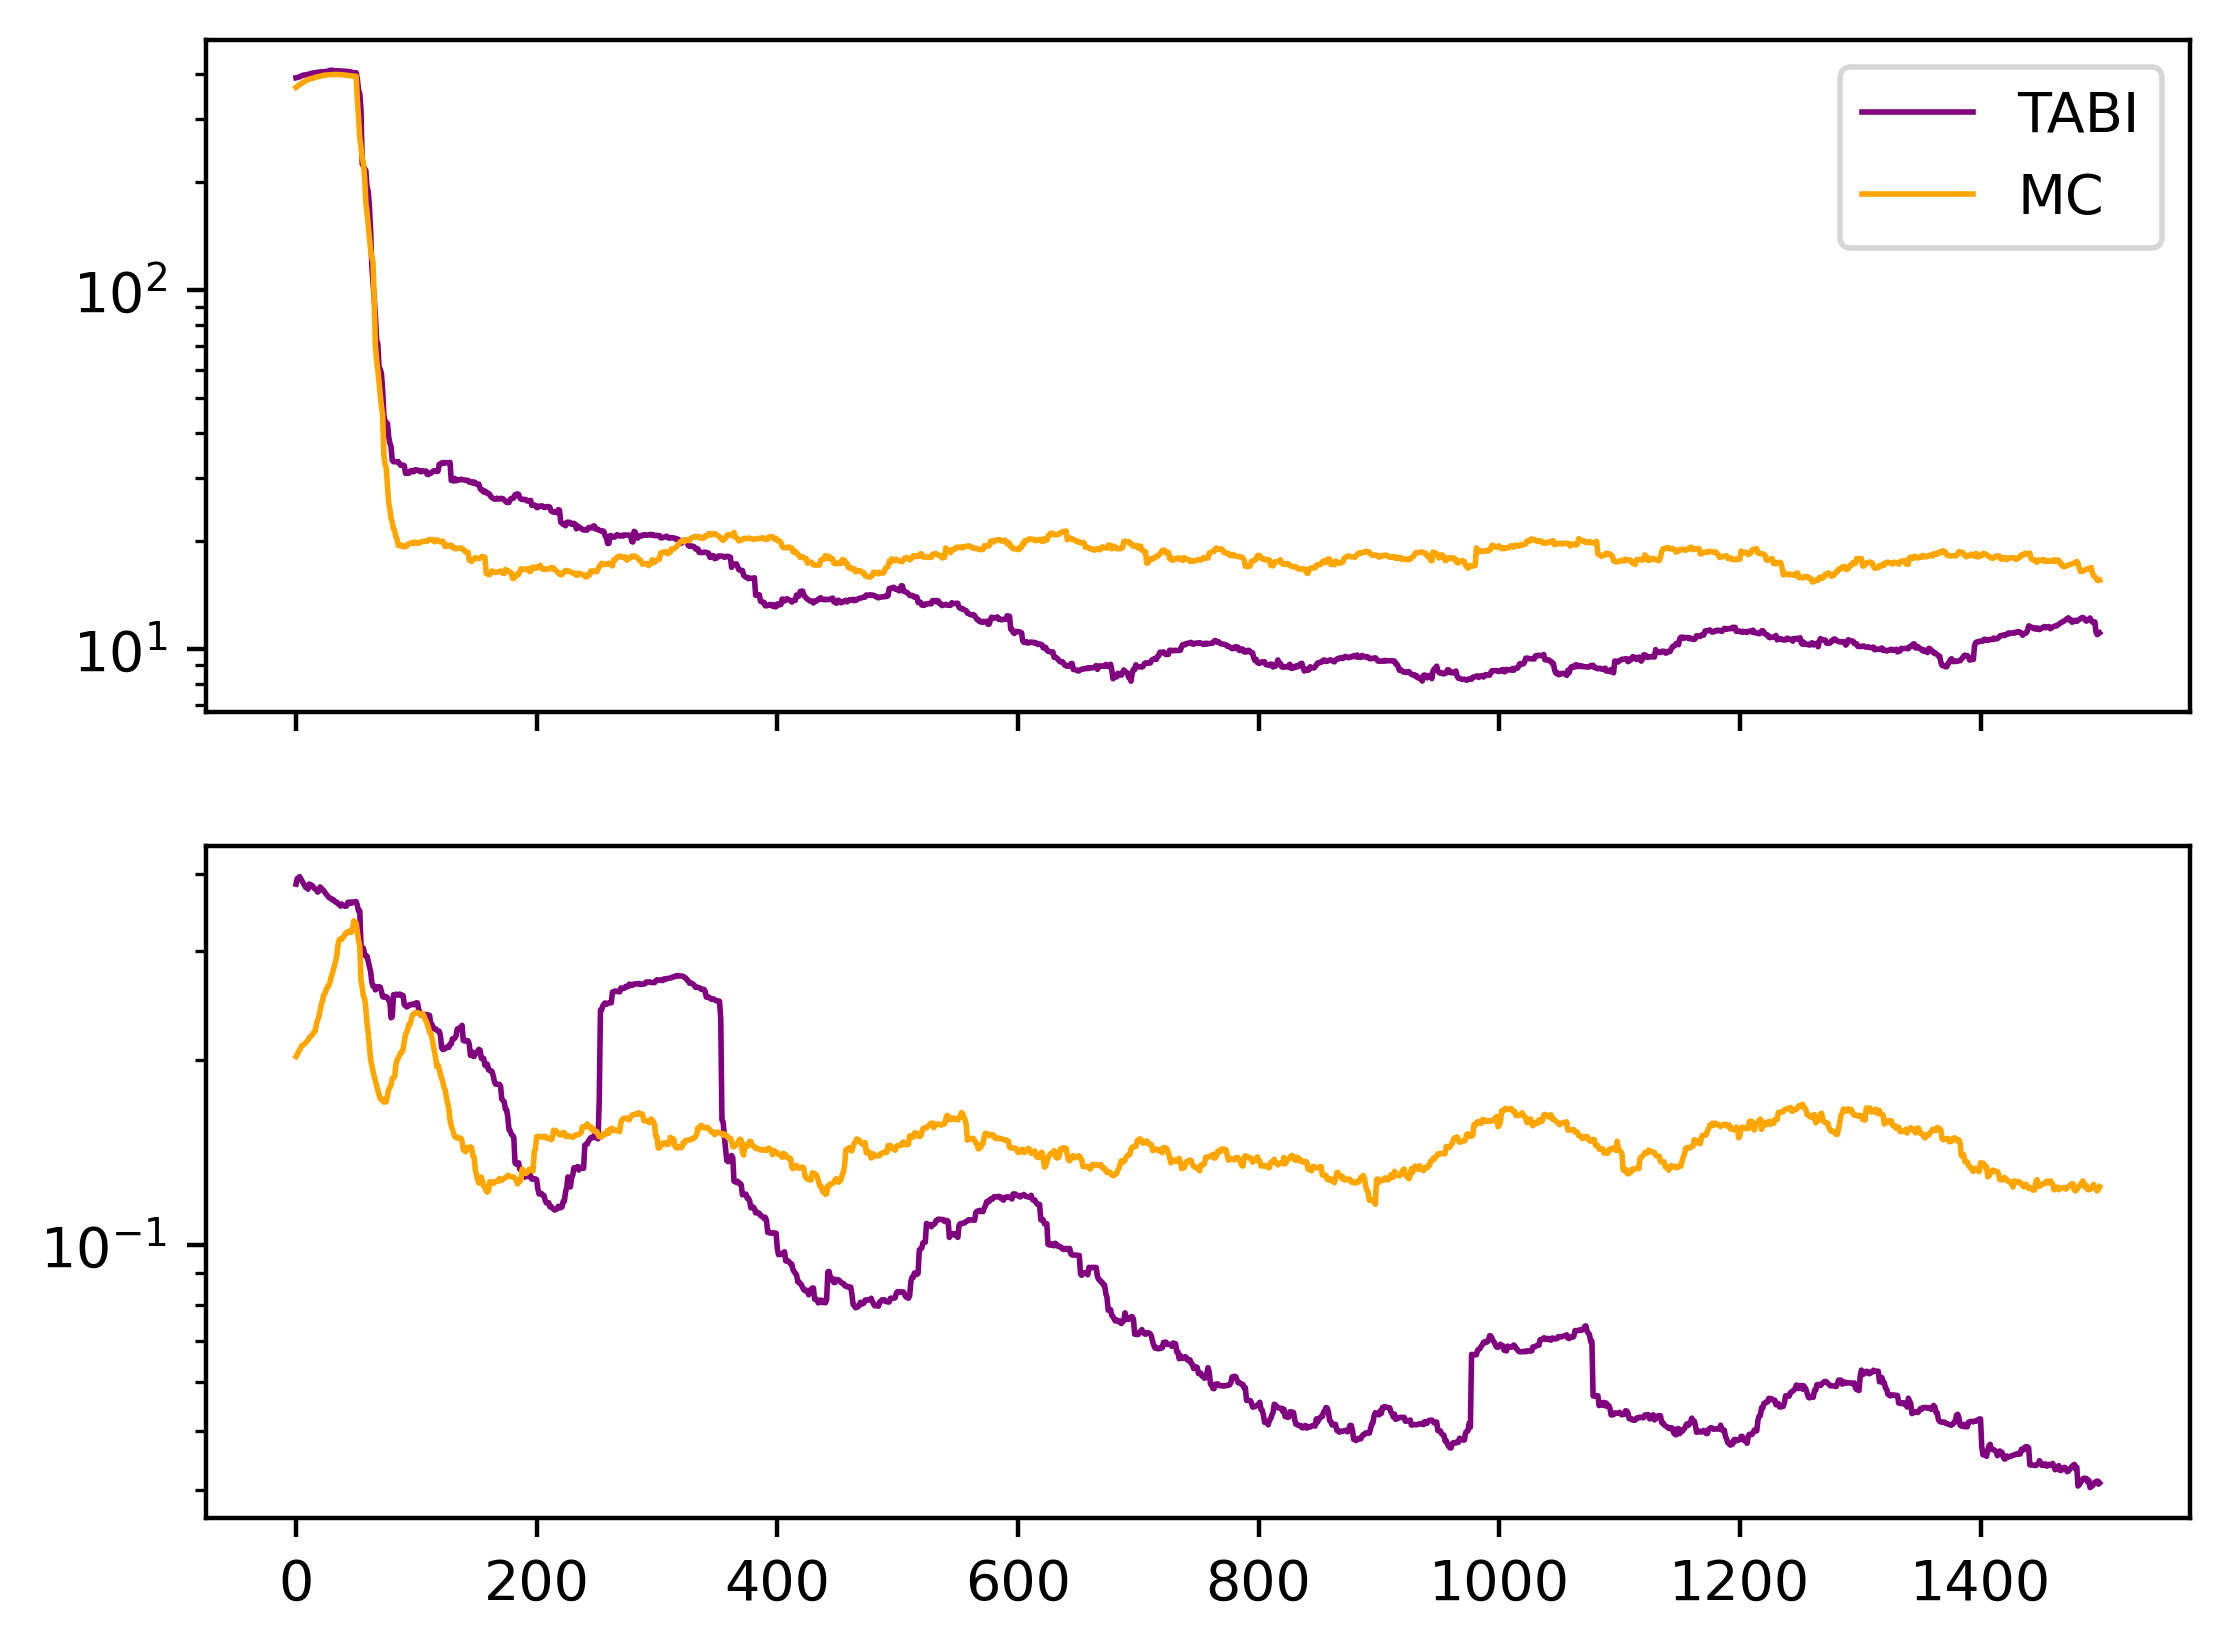

In [33]:
# DEBUG
fig, axs = plt.subplots(2, 1, sharex=True, dpi=400)

# Copy the original grad_estimates and nan-ify anything outside the .9th quantile.
tt_grad_estimates_nanned = tt_grad_estimates.clone()
# tt_grad_estimates_nanned[tt_grad_estimates_nanned.abs() > tt_grad_estimates_no_nan.abs().quantile(.93)] = float('nan')
tt_mc_grad_estimates_nanned = tt_mc_grad_estimates.clone()
# tt_mc_grad_estimates_nanned[tt_mc_grad_estimates_nanned.abs() > tt_mc_grad_estimates_no_nan.abs().quantile(.9)] = float('nan')

start = 0

axs[0].plot(tt_grad_estimates_nanned[start:, 0], linewidth=0.1, color='purple')
axs[0].plot(tt_mc_grad_estimates_nanned[start:, 0], linewidth=0.1, color='orange')
axs[1].plot(tt_grad_estimates_nanned[start:, 1], linewidth=0.1, color='purple')
axs[1].plot(tt_mc_grad_estimates_nanned[start:, 1], linewidth=0.1, color='orange')

axs[0].plot([], linewidth=1., color='purple', label="TABI")
axs[0].plot([], linewidth=1., color='orange', label="MC")
axs[0].legend()


# Plot the sliding window standard deviations of the two.
fig, axs = plt.subplots(2, 1, sharex=True, dpi=400)
axs[0].plot(sliding_window_std_linear_fit(tt_grad_estimates_nanned[start:, 0].numpy(), 100), linewidth=1., color='purple', label="TABI")
axs[0].plot(sliding_window_std_linear_fit(tt_mc_grad_estimates_nanned[start:, 0].numpy(), 100), linewidth=1., color='orange', label="MC")
axs[1].plot(sliding_window_std_linear_fit(tt_grad_estimates_nanned[start:, 1].numpy(), 100), linewidth=1., color='purple', label="TABI")
axs[1].plot(sliding_window_std_linear_fit(tt_mc_grad_estimates_nanned[start:, 1].numpy(), 100), linewidth=1., color='orange', label="MC")
axs[0].legend()

# Make y axes logscale.
axs[0].set_yscale('log')
axs[1].set_yscale('log')

##### Comparison

In [34]:
def plot_parameter_optimization(capacity_param, research_param, ax0, ax1, **kwargs):

    ax0.plot(capacity_param, **kwargs)
    ax0.set_title("Capacity to Build")
    ax1.plot(research_param, **kwargs)
    ax1.set_title("Opp Cost of Research")

    # plt.figure()
    # plt.plot(capacity_param, research_param)
    # plt.xlabel("Capacity to Build")
    # plt.ylabel("Opp Cost of Research")

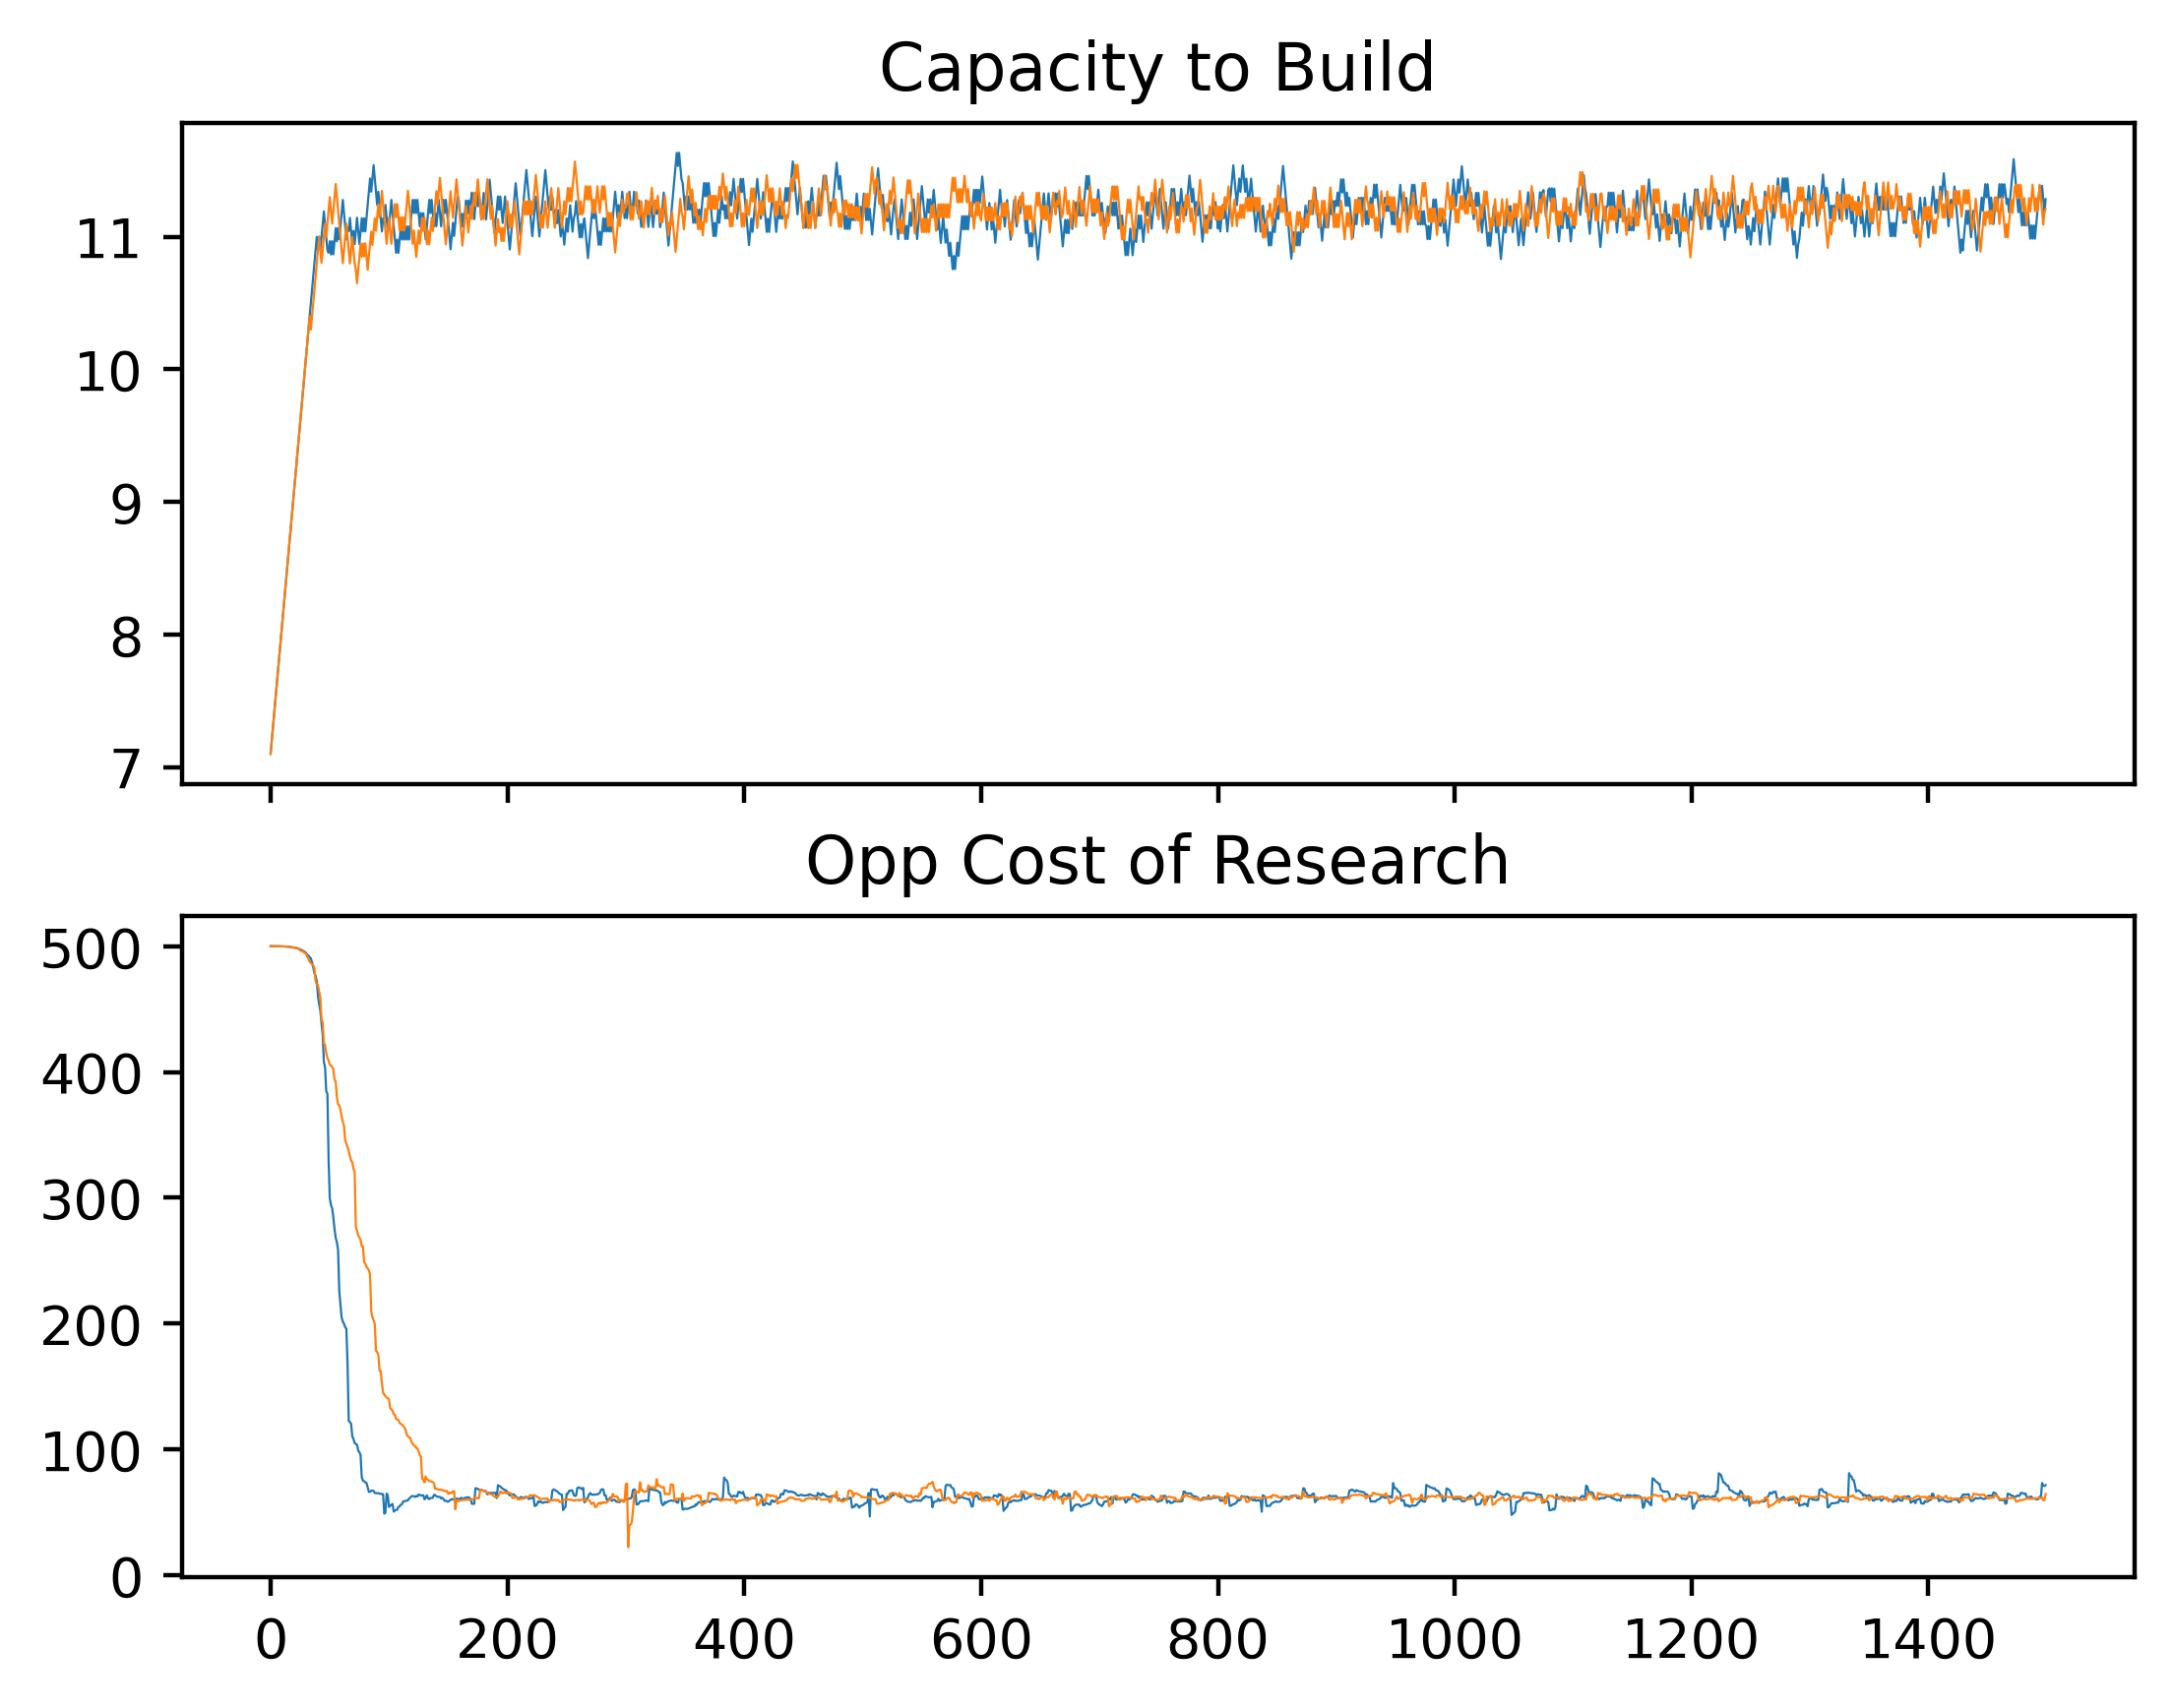

In [35]:
fig, axs = plt.subplots(2, 1, sharex=True, dpi=400)
# slc = slice(4000, 5000, 1)
slc = slice(None, None)
# slc = slice(500, 800)
plot_parameter_optimization(capacity_param_pmmdo[slc], research_param_pmmdo[slc], *axs, linewidth=0.4)
plot_parameter_optimization(capacity_param_pmmdo_tabi[slc], research_param_pmmdo_tabi[slc], *axs, linewidth=0.4)

plot_cost(pp)

plot_raw_margin(pp, n=25000)

plot_margin(-1., pp, n=25000)